In [3]:
from utils import *
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import poisson, chisquare
import pickle

In [4]:
base_url = "https://www.football-data.co.uk/mmz4281/{}/E0.csv"
season = "1415"
df = get_match_data(base_url.format(season)).sort_values(by="MatchWeek")
ws = get_winstreak(df)

In [6]:
train = df[df["MatchWeek"]<26]
test = df[df["MatchWeek"]>=26]

In [7]:
### Train params

params = np.ones((4,20))

num_itrs = 50000
lr = 0.0001

for i in tqdm(range(num_itrs)):
    batch = train.sample(frac=1/20)

    for index, row in batch.iterrows():

        home_index = teams_ind[row["HomeTeam"]]
        away_index = teams_ind[row["AwayTeam"]]
        home_goal = row["FTHG"]
        away_goal = row["FTAG"]

        # update home team params
        params[0,home_index] += lr * (home_goal / params[0,home_index] - params[3,away_index])
        params[1,home_index] += lr * (away_goal / params[1,home_index] - params[2,away_index])

        # update away team params
        params[2,away_index] += lr * (away_goal / params[2,away_index] - params[1,home_index])
        params[3,away_index] += lr * (home_goal / params[3,away_index] - params[0,home_index])

100%|██████████| 50000/50000 [01:05<00:00, 767.05it/s]


In [8]:
team_params = np.ones((4,20))
streak_param = 1

num_itrs = 50000
lr = 0.0001

for i in tqdm(range(num_itrs)):
    batch = train.sample(frac=1/20)

    for index, row in batch.iterrows():

        home_index = teams_ind[row["HomeTeam"]]
        away_index = teams_ind[row["AwayTeam"]]
        home_goal = row["FTHG"]
        away_goal = row["FTAG"]
        week = row["MatchWeek"]
        home_streak = ws.loc[week,row["HomeTeam"]]
        away_streak = ws.loc[week,row["AwayTeam"]]

        # update home team params
        team_params[0,home_index] += lr * (home_goal / team_params[0,home_index] - team_params[3,away_index] * (streak_param ** home_streak))
        team_params[1,home_index] += lr * (away_goal / team_params[1,home_index] - team_params[2,away_index] * (streak_param ** away_streak))
        if home_streak != 0:
            streak_param += lr * (home_goal * home_streak / streak_param - home_streak * team_params[0,home_index] * team_params[3,away_index] * (streak_param ** (home_streak - 1)))

        # update away team params
        team_params[2,away_index] += lr * (away_goal / team_params[2,away_index] - team_params[1,home_index] * (streak_param ** away_streak))
        team_params[3,away_index] += lr * (home_goal / team_params[3,away_index] - team_params[0,home_index] * (streak_param ** home_streak))
        if away_streak != 0:
            streak_param += lr * (away_goal * away_streak / streak_param - away_streak * team_params[2,away_index] * team_params[1,home_index] * (streak_param ** (away_streak - 1)))


100%|██████████| 50000/50000 [01:40<00:00, 497.55it/s]


In [16]:
# ## Save trained params DON'T UNCOMMENT
# saved_params = [params, team_params, streak_param]
# with open('betting_params.pickle', 'wb') as f:
#     # Pickle the 'data' dictionary using the highest protocol available.
#     pickle.dump(saved_params, f, pickle.HIGHEST_PROTOCOL)

In [17]:
with open('betting_params.pickle', 'rb') as f:
    saved_params = pickle.load(f)

params = saved_params[0]
team_params = saved_params[1]
streak_param = saved_params[2]

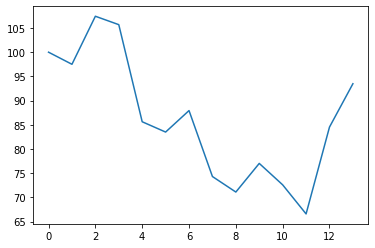

In [56]:
current = 100.00
history = [current]
matchweek = [20]

results_dict = {0: "H", 1: "D", 2: "A"}

for i, row in test.iterrows():
    home_index = teams_ind[row["HomeTeam"]]
    away_index = teams_ind[row["AwayTeam"]]
    result = row["FTR"]
    
    house_odds = np.array([row["B365H"], row["B365D"], row["B365A"]])
    model_odds = get_odds(params, home_index, away_index)

    kelly = kelly_criterion(house_odds, model_odds)
    best_bet = np.argmax(kelly)

    if kelly[best_bet] > 0:
        if kelly[best_bet] > 0.025:
            kelly[best_bet] = 0.025
        
        bet = round(current * kelly[best_bet],2)
        
        current -= bet

        if results_dict[best_bet] == row["FTR"]: # Win the bet
            current += bet * house_odds[best_bet]
            current = round(current, 2)
    if row["MatchWeek"] != matchweek[-1]:
        history.append(current)
        matchweek.append(row["MatchWeek"])
    
plt.plot(history)

In [57]:
### Simpler model to compare

train_standings = get_standings(train)
avg_goals = sum(train_standings["GF"])/(25*10)

simple_params = np.zeros((4,20))

for j,team in train_standings.iterrows():
    i = teams_ind[team["Team"]]
    simple_params[0,i] = (team["GF"] / 25) / avg_goals
    simple_params[2,i] = (team["GF"] / 25) / avg_goals
    simple_params[1,i] = (team["GA"] / 25) / avg_goals
    simple_params[3,i] = (team["GA"] / 25) / avg_goals
simple_params *= avg_goals

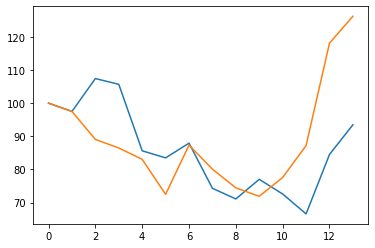

In [58]:
current = 100.00
history2 = [current]
matchweek = [20]

results_dict = {0: "H", 1: "D", 2: "A"}

for i, row in test.iterrows():
    home_index = teams_ind[row["HomeTeam"]]
    away_index = teams_ind[row["AwayTeam"]]
    result = row["FTR"]
    
    house_odds = np.array([row["B365H"], row["B365D"], row["B365A"]])
    model_odds = get_odds(simple_params, home_index, away_index)

    kelly = kelly_criterion(house_odds, model_odds)
    best_bet = np.argmax(kelly)

    if kelly[best_bet] > 0:
        if kelly[best_bet] > 0.025:
            kelly[best_bet] = 0.025
        
        bet = round(current * kelly[best_bet],2)
        
        current -= bet

        if results_dict[best_bet] == row["FTR"]: # Win the bet
            current += bet * house_odds[best_bet]
            current = round(current, 2)
    if row["MatchWeek"] != matchweek[-1]:
        history2.append(current)
        matchweek.append(row["MatchWeek"])

In [ ]:
plt.plot(history, matchweek)
plt.plot(history2, matchweek)